In [2]:
from pyarrow import timestamp
from welfareobs.detectron.detectron_configuration import get_configuration
from welfareobs.detectron.detectron_calls import image_tensor, predict
from welfareobs.detectron.welfareobs_dataset import WelfareObsDataset
from detectron2.config import instantiate
from detectron2.checkpoint import DetectionCheckpointer
from welfareobs.handlers.abstract_handler import AbstractHandler
from welfareobs.models.frame import Frame
from welfareobs.models.individual import Individual
from welfareobs.utils.config import Config
from welfareobs.utils.bgr_transform import BGRTransform 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import os
import itertools
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss, roc_auc_score
from sklearn.exceptions import ConvergenceWarning
import warnings



In [ ]:
"""
Notebook configuration parameters:
"""
config_name = "config/detection.json" # used in the pipelines
num_images = 1000 # total number of images to load
batch_size = 100 # batch size (tuned for the GPU)


In [3]:
"""
Load up the configuration
"""

cnf: Config = Config(config_name)
dimensions = cnf.as_int("dimensions")
reid_model_root = cnf.as_string("reid-model-root")
reid_timm_backbone = cnf.as_string("reid-timm-backbone")
segmentation_checkpoint = cnf.as_string("segmentation-checkpoint")
print("Configuration set")

Configuration set


In [4]:
"""
Load the model
"""


print(f"Reading model {reid_model_root}.")
model = instantiate(
    get_configuration(
        reid_model_root,
        backbone=reid_timm_backbone,
        dimensions=dimensions
    )
)
# then load it with the pretrained backbone
DetectionCheckpointer(model).load(segmentation_checkpoint)
model.eval()
model = model.to("cuda")


Reading model /project/data/results/wod-md.


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (BVRA/wildlife-mega-L-384)
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /project/data/detectron2_models/mask_rcnn_R_101_FPN_3x/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /project/data/detectron2_models/mask_rcnn_R_101_FPN_3x/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


In [5]:
"""
Load the dataset for evaluation
"""


dataset=WelfareObsDataset(
    root="/project/data/wod_reid",
    annotations_file="coco_test.json",   # change this to test against the training data
    transform = T.Compose([
        T.PILToTensor(), # Convert a PIL Image or ndarray to tensor and scale the values 0->255 to 0.0->1.0
        T.Resize(
            size=(dimensions,dimensions),
            interpolation=T.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True
        ),
        # note that we do NOT normalise the image because that is happening inside Detectron2
        BGRTransform()  # since our data source is RGB
        # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]),
    img_load="bbox", # "bbox_mask",
    col_path="path",
    col_label="identity",
    load_label=True
)




Reading test dataset.


In [32]:
"""
Dump image sample (only works for small values of num_images)
"""
# fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(10, 10*num_images))
# for index, (item, ax) in enumerate(zip(itertools.islice(dataset, num_images),axs)):
#     ax.imshow(np.array(item[0]).transpose(1, 2, 0)[ :, : ,[2, 1, 0]])  # 
#     ax.axis('off')


'\nDump image sample (only works for small values of num_images)\n'

In [20]:
known_classes = []
prediction_classes = []

subset = itertools.islice(dataset, num_images)
for i in range(0, num_images, batch_size):
    image_tensors = []
    print(f"Batch {i/batch_size}")
    for item in itertools.islice(subset, batch_size):
        image_tensors.append(item[0])
        known_classes.append(dataset.labels_map[item[1]])
    torch.cuda.empty_cache()
    if len(image_tensors) > 0:
        output = predict(image_tensors, model)
        for index, item in enumerate(output):
            item = item["instances"]
            step_result = 0
            if item.has("reid_embeddings"):
                _reids = list(item.get("reid_embeddings").cpu().numpy().flatten())
                _scores = list(item.get("scores").cpu().numpy())
                for i in range(len(item)):
                    if _reids[i] != -1:
                        step_result = _reids[i]
            prediction_classes.append(step_result)


Batch 0.0
Batch 1.0
Batch 2.0
Batch 3.0
Batch 4.0
Batch 5.0
Batch 6.0
Batch 7.0
Batch 8.0
Batch 9.0


In [ ]:
#    print(f"{index} {known_classes[index]==prediction_classes[index]} {known_classes[index]} {prediction_classes[index]}")

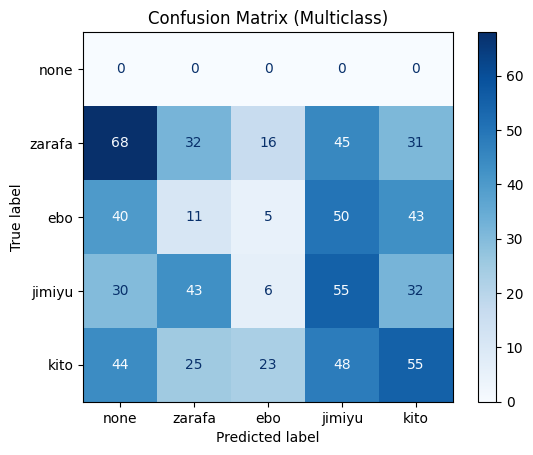

In [21]:
# Generate and display the confusion matrix
cm = confusion_matrix(known_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["none", "zarafa", "ebo", "jimiyu", "kito"])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()
